# Die Stimmungserkennung (SER)

## Inhalt

* [Tensorboard](#Tensorboard)
* [Python-Bibliotheken](#Bibliotheken)
* [Die Vorverarbeitung](#Vorverarbeitung)  
    * [Die Datenbeladung](#Datenbeladung)    
    * [Die Datenvisualisierung](#datenvisual)
* [Das Klassifikationsmodell](#klassifikationsmodell)
    * [Die Modellskonfiguration](#modelskonfiguration)
    * [Die Modellstruktur](#modellstruktur)
    * [Modell-Training](#modelltraining)
* [Save Modell](#savemodell)
* [Test Modell](#testmodell)
    * [Die Ganauigkeit](#ganauigkeit)
    * [Die Metriken](#metriken)

## Tensorboard<a class="anchor" id="Tensorboard"></a>

#### Tensorboard ist eine Webanwendung zur Visualisierungverschidener Aspekte neuronaler Netze

In [ ]:
from keras.backend import clear_session
clear_session()
%reload_ext tensorboard

## Python-Bibliotheken<a class="anchor" id="Bibliotheken"></a>

In [ ]:
import torch
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from torchvision import models, transforms
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torchvision
from functools import partial
import keras
import itertools
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix

## Die Vorverarbeitung<a class="anchor" id="Vorverarbeitung"></a>

In [ ]:
# "surprise" wird von 8 auf 0 geändert
EMOTIONS = {0:'neutral', 1:'happy', 2:'sad', 3:'angry', 4:'fear', 5:'disgust', 6:'surprise'} 

In [ ]:
# Audiodateien
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/My Drive')
gdrive_path = os.getcwd()

Mounted at /content/drive


In [ ]:
path_model = Path.cwd() / "ravdess" / "modell" / "path_model.h5"
#PATH_TO_RAVDESS = Path.cwd() / "ravdess" / "frequenzbereich_new"
PATH_TO_RAVDESS = Path.cwd() /"frequenzbereich_new"
PATH_RAVDESS_TRAIN = PATH_TO_RAVDESS / "train"
PATH_RAVDESS_TEST = PATH_TO_RAVDESS / "test"
PATH_RAVDESS_VALID = PATH_TO_RAVDESS / "valid"
bs = 1440

In [ ]:
# Confusion Matrix
class_names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix (Keras ResNet - Modell)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
  #      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

 #   print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Die Datenbeladung<a class="anchor" id="Datenbeladung"></a>

In [ ]:
class PrecomputedRavdess(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))
        self.items = [(f,int(f.name.split("-")[2].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.img_transforms(img), label)
            
    def __len__(self):
        return self.length

In [ ]:
def LoadRavdess():

    ravdess_train = PrecomputedRavdess(PATH_RAVDESS_TRAIN,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
    )

    ravdess_test = PrecomputedRavdess(PATH_RAVDESS_TEST,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
    )
    
    ravdess_valid = PrecomputedRavdess(PATH_RAVDESS_VALID,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
    )

    ravdess_train_loader = torch.utils.data.DataLoader(ravdess_train, bs, shuffle=True)
    ravdess_test_loader = torch.utils.data.DataLoader(ravdess_test, bs, shuffle=True)
    ravdess_valid_loader = torch.utils.data.DataLoader(ravdess_valid, bs, shuffle=True)
    spectogram = torch.utils.data.DataLoader(ravdess_train,64,shuffle=True )         
    return ravdess_train_loader, ravdess_test_loader, ravdess_valid_loader,spectogram

In [ ]:
ravdess_train_loader, ravdess_test_loader, ravdess_valid_loader, spectogram = LoadRavdess()

### Die Datenvisualisierung<a class="anchor" id="#datenvisual"></a>

Train Labels: tensor([3, 5, 2, 3, 4, 3, 2, 1, 1, 2, 1, 4, 0, 3, 2, 5, 5, 4, 3, 0, 0, 3, 5, 3,
        3, 1, 0, 5, 6, 4, 1, 1, 2, 4, 1, 5, 2, 6, 4, 4, 0, 2, 2, 4, 1, 5, 5, 4,
        0, 4, 4, 1, 3, 4, 2, 4, 5, 0, 3, 1, 4, 4, 6, 2])


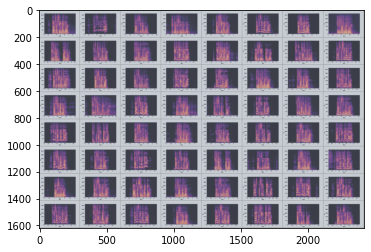

In [ ]:
def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()
img, label = next(iter(spectogram))       
images_train, labels_train = next(iter(ravdess_train_loader))  
images_test, labels_test = next(iter(ravdess_test_loader))
images_valid, labels_valid = next(iter(ravdess_valid_loader))
print("Train Labels:",label)
imshow(torchvision.utils.make_grid(img)/ 4)

## Das Klassifikationsmodell<a class="anchor" id="#klassifikationsmodell"></a>

### Die Modellskonfiguration<a class="anchor" id="#modelskonfiguration"></a>

In [ ]:
batch_size = 64
img_width, img_height, img_num_channels = 3,200,300
loss_function = sparse_categorical_crossentropy
no_classes = 7
optimizer = Adam()
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [ ]:
# Residual Unit-Schicht
# Im Konstruktor werden alle erforderlichen Schichten erzeugt
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
#Das ResNet-34 kann mit einem Sequential-Modell angebaut werden.
def build_model():
    model = keras.models.Sequential()
    model.add(DefaultConv2D(64, kernel_size=3, strides=1,
                        input_shape= input_shape ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 7
    for filters in [64] * 1 + [128] * 1 + [256] * 1: 
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(no_classes, activation="softmax"))
    optimizer = keras.optimizers.Nadam(lr=1e-3)
    model.compile(loss=loss_function,
              optimizer=optimizer,  metrics=['accuracy'])
    return model

In [ ]:
# Datentyp-Umwandelung
images_train = (tf.cast(images_train, tf.float32) / 255).numpy()
labels_train = labels_train.numpy()
images_valid = (tf.cast(images_valid, tf.float32) / 255).numpy()
labels_valid = labels_valid.numpy()
images_test = (tf.cast(images_test, tf.float32) / 255).numpy()
labels_test = labels_test.numpy()

### Die Modellstruktur<a class="anchor" id="#modellstruktur"></a>

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 200, 64)        172800    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 200, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 3, 200, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 100, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 1, 50, 64)         78592     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 1, 25, 128)        230912    
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 1, 13, 256)        9

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Modell-Training<a class="anchor" id="#modelltraining"></a>

In [ ]:
history = model.fit(images_train, labels_train,
            batch_size=batch_size,
            epochs=100,        
            verbose=verbosity,
            validation_data = (images_valid, labels_valid)) 

Epoch 1/100
14/14 [==============================] - 32s 1s/step - loss: 1.9592 - accuracy: 0.2123 - val_loss: 1.9476 - val_accuracy: 0.1366
Epoch 2/100
14/14 [==============================] - 16s 1s/step - loss: 1.6135 - accuracy: 0.3740 - val_loss: 1.9580 - val_accuracy: 0.1366
Epoch 3/100
14/14 [==============================] - 16s 1s/step - loss: 1.3174 - accuracy: 0.4881 - val_loss: 1.9958 - val_accuracy: 0.1366
Epoch 4/100
14/14 [==============================] - 16s 1s/step - loss: 1.1800 - accuracy: 0.5376 - val_loss: 2.0514 - val_accuracy: 0.1366
Epoch 5/100
14/14 [==============================] - 16s 1s/step - loss: 1.0180 - accuracy: 0.6118 - val_loss: 2.1299 - val_accuracy: 0.1366
Epoch 6/100
14/14 [==============================] - 16s 1s/step - loss: 0.8519 - accuracy: 0.6834 - val_loss: 2.2665 - val_accuracy: 0.1366
Epoch 7/100
14/14 [==============================] - 16s 1s/step - loss: 0.6996 - accuracy: 0.7686 - val_loss: 2.4674 - val_accuracy: 0.1366
Epoch 8/100
1

#### Die Genauigkeit

In [ ]:
loss, acc = model.evaluate(images_train, labels_train)
print("Train, accuracy: {:5.2f}%".format(100*acc))

27/27 [==============================] - 4s 165ms/step - loss: 0.3150 - accuracy: 0.8946
Train, accuracy: 89.46%


In [ ]:
loss_valid, acc_valid = model.evaluate(images_valid, labels_valid)
print("Train, accuracy: {:5.2f}%".format(100*acc))

8/8 [==============================] - 1s 145ms/step - loss: 2.7113 - accuracy: 0.4537
Train, accuracy: 89.46%


#### Die Metriken

14/14 [==============================] - 6s 335ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       123
           1       1.00      1.00      1.00       118
           2       0.77      1.00      0.87       125
           3       0.79      1.00      0.88       121
           4       1.00      0.40      0.57       124
           5       0.93      0.88      0.90       121
           6       0.94      1.00      0.97       122

    accuracy                           0.89       854
   macro avg       0.91      0.90      0.88       854
weighted avg       0.91      0.89      0.88       854

Confusion matrix, without normalization


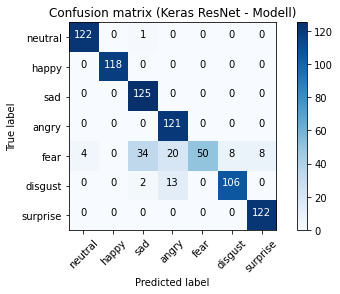

In [ ]:
y_pred_train = model.predict(images_train, batch_size=64, verbose=1)
y_pred_b = np.argmax(y_pred_train, axis=1)

print(classification_report(labels_train, y_pred_b))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(labels_train, y_pred_b), classes=class_names)
plt.show()

#### Visualisierung

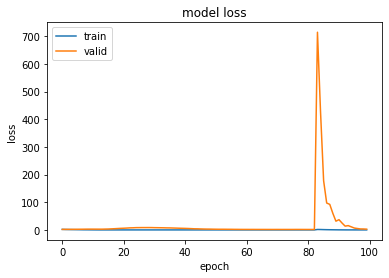

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

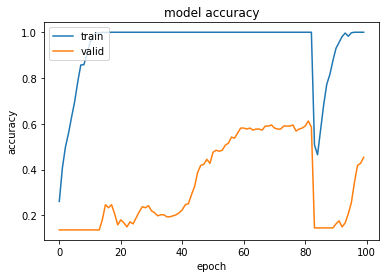

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

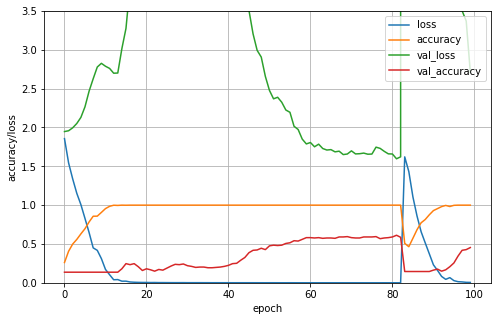

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.gca().set_ylim(0, 3.5)
plt.show()

## Save Modell<a class="anchor" id="#savemodell"></a>

In [ ]:
model.save_weights(path_model)

## Test Modell<a class="anchor" id="#testmodell"></a>

In [ ]:
model_test = build_model()
model_test.load_weights(path_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Die Ganauigkeit<a class="anchor" id="#ganauigkeit"></a>

In [ ]:
loss, acc = model_test.evaluate(images_test, labels_test)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

9/9 [==============================] - 3s 153ms/step - loss: 2.0963 - accuracy: 0.5454
Restored model, accuracy: 53.99%


### Die Metriken<a class="anchor" id="#metriken"></a>

5/5 [==============================] - 2s 259ms/step
              precision    recall  f1-score   support

           0       0.61      0.37      0.46        38
           1       0.88      0.84      0.86        43
           2       0.32      0.66      0.43        35
           3       0.38      0.53      0.44        38
           4       0.60      0.09      0.15        34
           5       0.68      0.50      0.58        38
           6       0.68      0.73      0.70        37

    accuracy                           0.54       263
   macro avg       0.59      0.53      0.52       263
weighted avg       0.60      0.54      0.53       263

Confusion matrix, without normalization


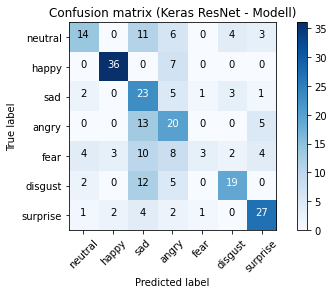

In [ ]:
y_pred = model_test.predict(images_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(labels_test, y_pred_bool))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(labels_test, y_pred_bool), classes=class_names)
plt.show()

In [ ]:
model_test.save_weights(path_model)